This notebook is used to complete the following actions:
- Load both train and test datasets.
- Process features to reduce complexity.
- Combine train and test datasets into a single dataframe.
- Cluster the data. 
- Identify which combination of the pretrained best represented each cluster. 

In [198]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from datetime import datetime

from sklearn.preprocessing import StandardScaler,  RobustScaler
from sklearn.pipeline import Pipeline

from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from sklearn.impute import SimpleImputer

In [199]:
#load train data
with open('/Users/jamisonproctor/Desktop/team_ceres/data/saved_dictionary.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [200]:
#load test data
with open('/Users/jamisonproctor/Desktop/team_ceres/data/raw/test_array.pkl', 'rb') as f:
    loaded_dict_test = pickle.load(f)

In [201]:
#format train data to dataframe, add HR features and remove the HR data.
df = pd.DataFrame(columns=['user', 'hr', 'hr_mean', 'hr_median', 'hr_std'])
for i, key in enumerate(loaded_dict.keys()):
    df.loc[i, 'user'] = key
    for j, sub_key in enumerate(loaded_dict.keys()):
        df.loc[j, 'hr'] = np.array([loaded_dict[sub_key]['heartrate']])
        df.loc[j, 'hr_mean'] = round(np.mean(df['hr'][j]), 2)
        df.loc[j, 'hr_median'] = round(np.median(df['hr'][j]), 2)
        df.loc[j, 'hr_std'] = round(np.std(df['hr'][j]), 2)
df.drop(['hr'], axis=1, inplace=True)
df

/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/jamisonproctor/opt/anaconda3/envs/makeathon/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encount

,user,hr_mean,hr_median,hr_std
0,APGIB2T,82.54,80.0,10.81
1,A9ZG5GR,68.06,67.0,11.95
2,A0N9NV4,81.63,80.0,14.15
3,AKTGD8X,74.63,70.0,14.68
4,AE2B3RH,87.79,82.0,18.86
...,...,...,...,...
112,A0KX894,76.85,75.0,14.68
113,AOYM4KG,66.48,60.0,17.2
114,AZIK4ZA,72.77,66.0,20.8
115,AWA2KJK,94.74,95.0,15.29


In [202]:
#format test data to dataframe, add HR features and remove the HR data.
df_test = pd.DataFrame(columns=['user', 'hr', 'hr_mean', 'hr_median', 'hr_std'])
for i, key in enumerate(loaded_dict_test.keys()):
    df_test.loc[i, 'user'] = key
    for j, sub_key in enumerate(loaded_dict_test.keys()):
        df_test.loc[j, 'hr'] = np.array([loaded_dict_test[sub_key]['heart_rate']])
        df_test.loc[j, 'hr_mean'] = round(np.mean(df_test['hr'][j]), 2)
        df_test.loc[j, 'hr_median'] = round(np.median(df_test['hr'][j]), 2)
        df_test.loc[j, 'hr_std'] = round(np.std(df_test['hr'][j]), 2)
df_test.drop(['hr'], axis=1, inplace=True)
df_test.head()

,user,hr_mean,hr_median,hr_std
0,test_39,74.56,73.4,10.25
1,test_28,70.28,69.91,7.04
2,test_31,68.59,68.0,7.3
3,test_3,63.34,62.11,7.41
4,test_1,50.95,50.12,4.64


In [203]:
#add lables to train and test dataframes
df['is_test'] = 0
df_test['is_test'] = 1

In [204]:
 #adding the test data to the bottom of the train dataframe
df = pd.concat([df, df_test], axis=0).reset_index()
df.head(), df.tail()

(   index     user hr_mean hr_median hr_std  is_test
 0      0  APGIB2T   82.54      80.0  10.81        0
 1      1  A9ZG5GR   68.06      67.0  11.95        0
 2      2  A0N9NV4   81.63      80.0  14.15        0
 3      3  AKTGD8X   74.63      70.0  14.68        0
 4      4  AE2B3RH   87.79      82.0  18.86        0,
      index     user hr_mean hr_median hr_std  is_test
 152     35  test_29   57.94      57.0   6.61        1
 153     36   test_4   61.62      58.0  11.95        1
 154     37   test_6   66.85      66.0   4.88        1
 155     38  test_21   67.34     66.69   6.55        1
 156     39  test_18   62.31      59.0  11.12        1)

2.550982684612775


<AxesSubplot:xlabel='hr_mean', ylabel='hr_std'>

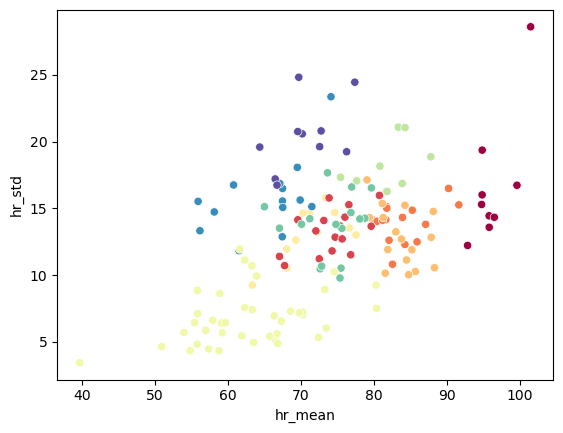

In [205]:
#cluster data
X = df.drop(['user'], axis=1)
kmedoids_pipeline = Pipeline([
        ("imputer", SimpleImputer(missing_values=np.nan, strategy='mean')),
        ("scaler", StandardScaler()),
        ("cluster", KMedoids(n_clusters=10))
        ])
clusters = kmedoids_pipeline.fit_predict(X)
df['medoid_cluster'] = clusters
print(df['medoid_cluster'].std())
df['has_model'] = 0
sns.scatterplot(x=df['hr_mean'], y=df['hr_std'], hue=df['medoid_cluster'], palette="Spectral", legend=False)

In [206]:
#label data with models
models = ['AQC0L71', 'AYWIEKR', 'AS2MVDL', 'AUY8KYW', 'AOYM4KG', 'AYEFCWQ', 'AKXN5ZZ', 'A3OU183', 'AAXAA7Z', 'A1K5DRI', 'A7EM0B6', 'AHYIJDV', 'AIFDJZB', 'AURCTAK', 'AV2GF3B', 'A4E0D03', 'AJWW3IY', 'A4G0044', 'APGIB2T', 'AMV7EQF', 'AA2KP1S', 'AX6281V', 'A0VFT1N', 'ASFODQR', 'A0NVTRV']
for row in df.index:
    if df['user'].loc[row] in models:
        df['has_model'][row] = 1

df.drop(['index'], axis=1, inplace=True)

/var/folders/0r/6jbjzk0n44n_phz8hy1gvsp80000gn/T/ipykernel_59550/91781043.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['has_model'][row] = 1


In [197]:
df.head()

,user,hr_mean,hr_median,hr_std,is_test,medoid_cluster,has_model
0,APGIB2T,82.54,80.0,10.81,0,2,1
1,A9ZG5GR,68.06,67.0,11.95,0,4,0
2,A0N9NV4,81.63,80.0,14.15,0,2,0
3,AKTGD8X,74.63,70.0,14.68,0,4,0
4,AE2B3RH,87.79,82.0,18.86,0,6,0


In [ ]:
df['has_model'].value_counts


In [ ]:
df_model_clusers = df[df['has_model'] == 1].reset_index().sort_values('medoid_cluster')
df_model_clusers.groupby('medoid_cluster')['user'].apply(list).reset_index(name='models for cluster')
models_per_cluster = df_model_clusers.groupby('medoid_cluster')['user'].apply(list).reset_index(name='models for cluster').set_index('medoid_cluster')
models_per_cluster

In [ ]:
df.to_csv('cluster_information')
models_per_cluster.to_csv('mapping of models to clusters')